## Objetivo

El dataset fue extrído de [Kaggle](https://www.kaggle.com/competitions/dog-breed-identification/data). El mismo presenta un problema de clasificación multi-clase, en donde el objetivo es identificar la raza de perros dentro del dataset. El mismo presenta los siguientes archivos:
- **datasets/classification/labels.csv**: contiene la raza de los perros de cada imágen.
- **datasets/classification/dog-breed-identification/train/**: contiene imágenes de entrenamiento.
- **datasets/classification/gog-breed-identification/test/**: contiene imágenes de testeo.

Dada la complejidad del problema en cuestión, se utilizará el approach de **Transfer Learning** utilizando un modelo pre-entrenado para lograr buen poder predictivo.

### Importing Libraries

In [30]:
import pandas as pd
import numpy as np
import requests
import shutil
import os
from io import BytesIO

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# import scikitplot as skplt

# ML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
from keras.applications.mobilenet import preprocess_input
from keras.applications import ResNet50V2
from keras.layers import BatchNormalization
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
import tensorflow as tf

# Computer Vision
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw, ImageFont

## Explanatory Data Analysis

### Data Loading

In [2]:
# Load targets
labels: pd.DataFrame = pd.read_csv(os.path.join("..", "datasets", "classification", "dog-breed-identification", "labels.csv"))

# Define train & test paths
train_dir = os.path.join("..", "datasets", "classification", "dog-breed-identification", "train")
test_dir = os.path.join("..", "datasets", "classification", "dog-breed-identification", "test")

In [3]:
# Show labels
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

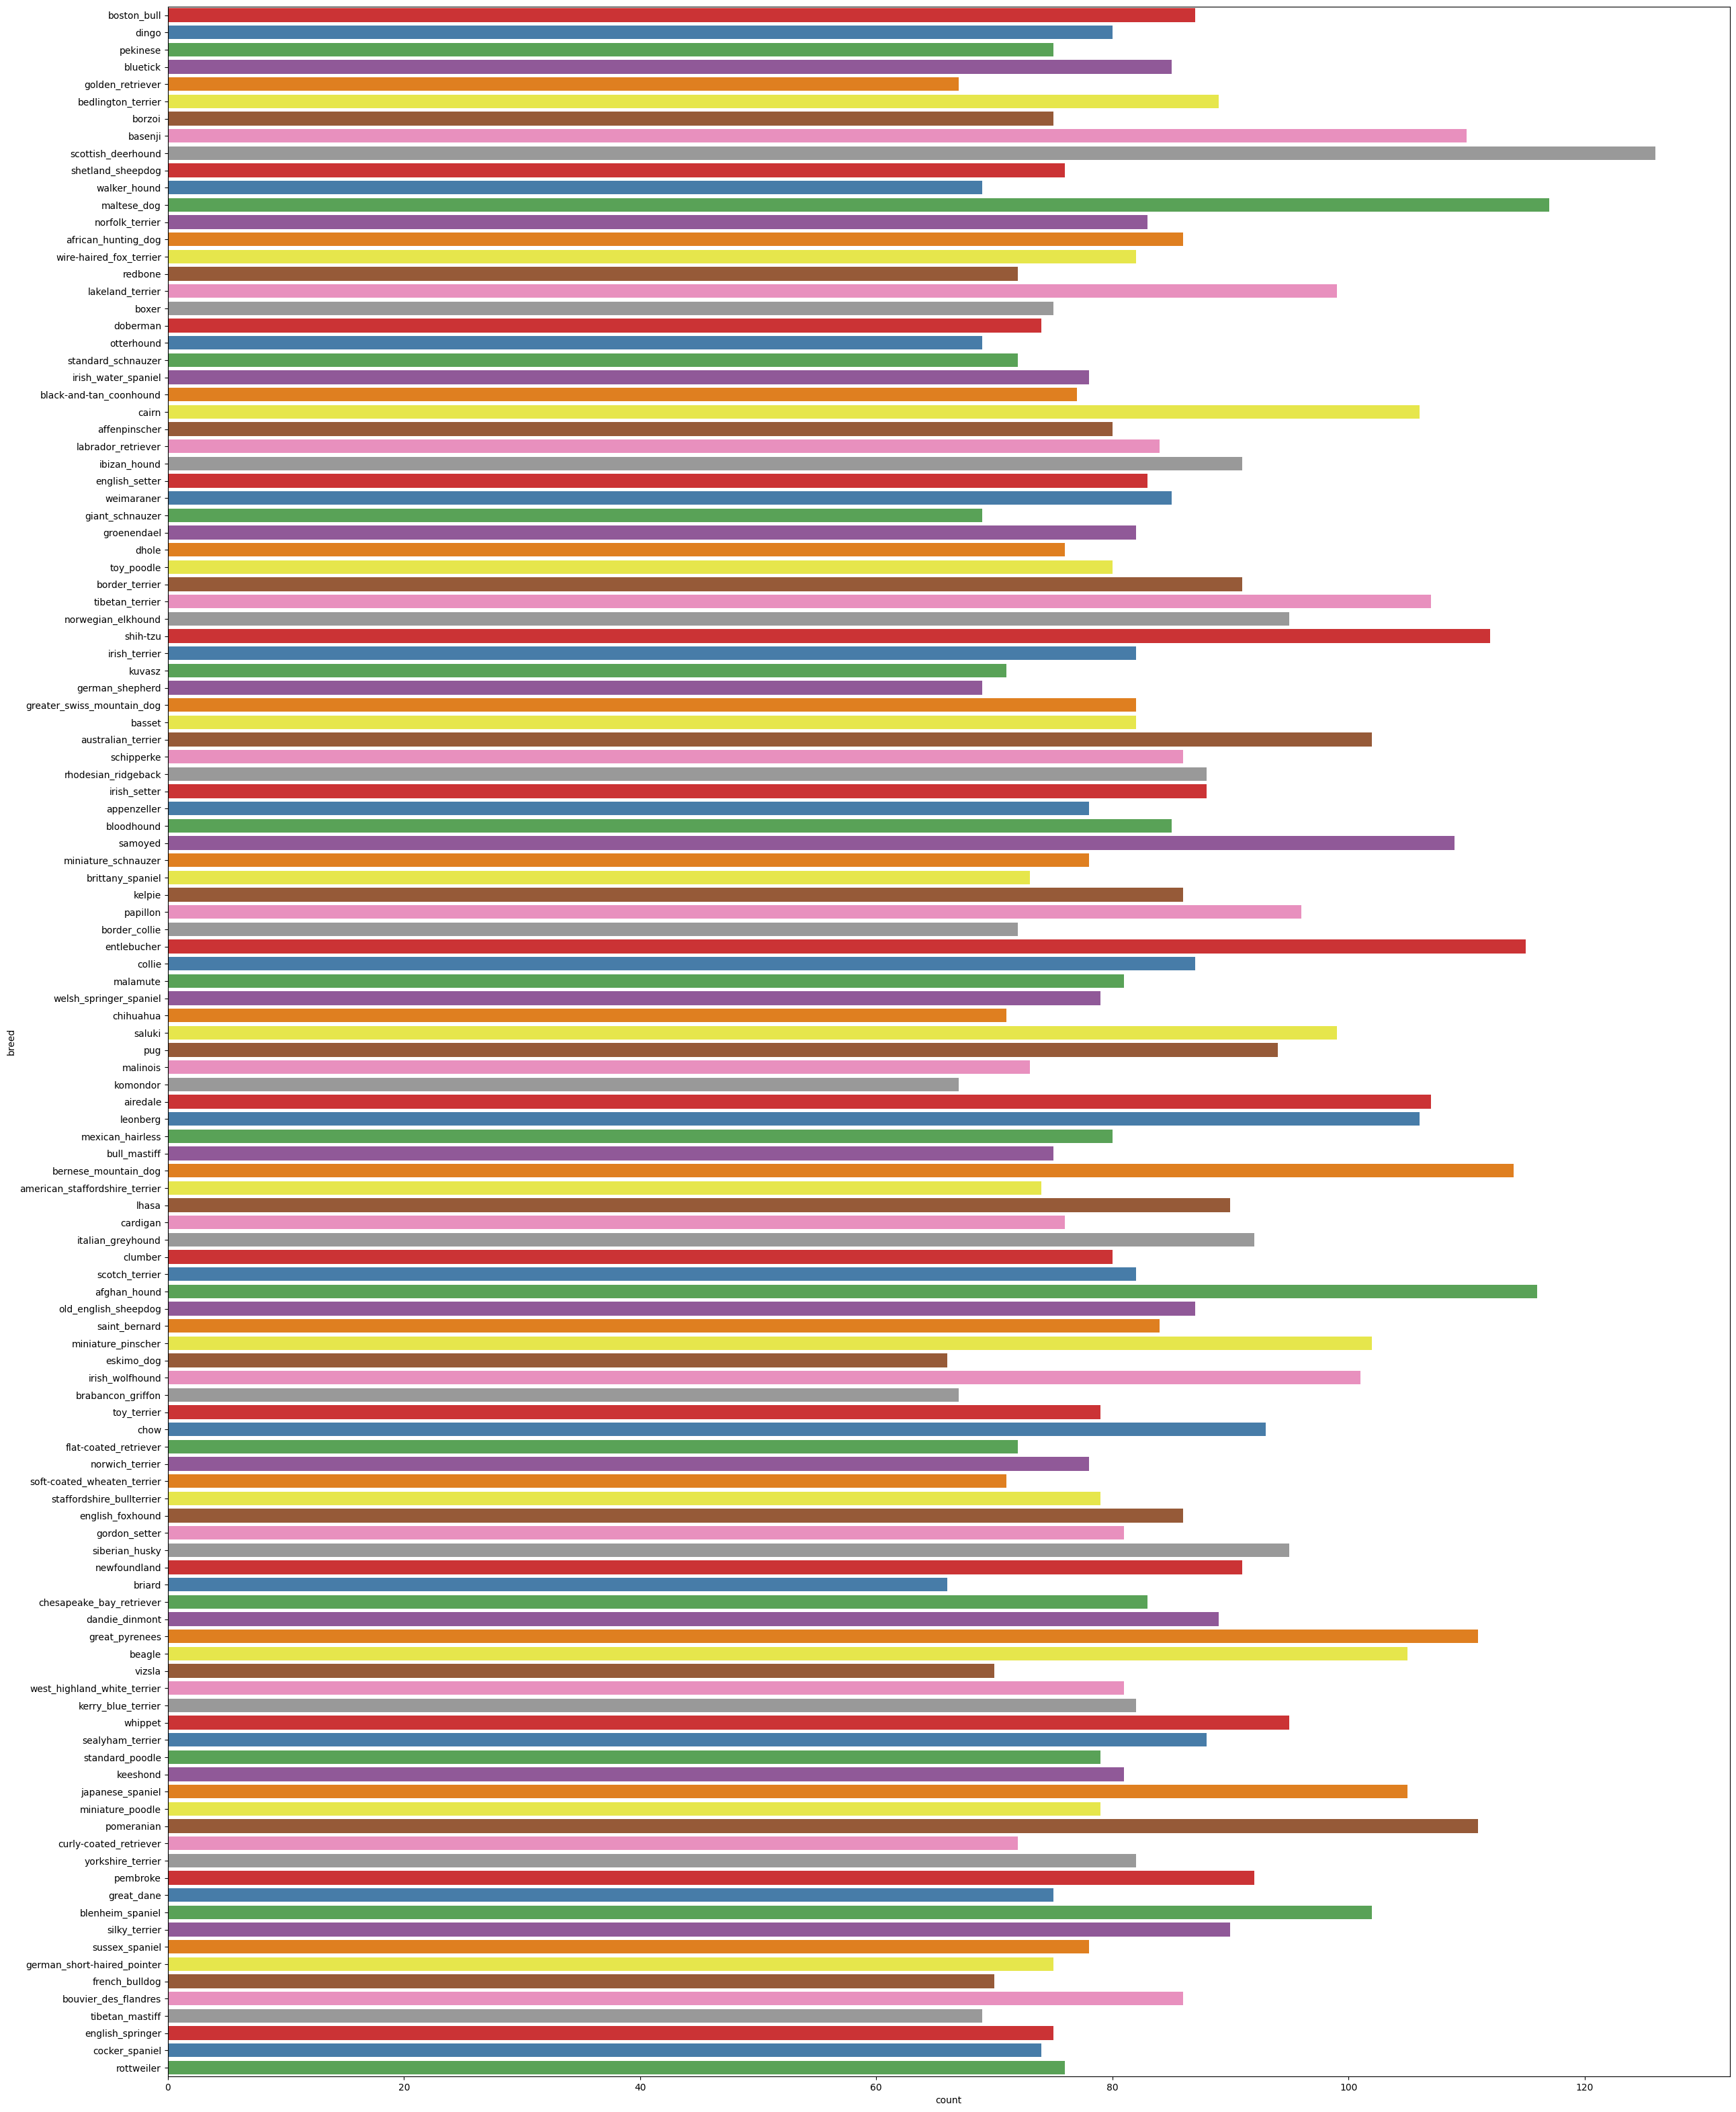

In [4]:
# Show barchart of labels
plt.figure(figsize=(30,40))
sns.countplot(
    y="breed", 
    data=labels,
    palette="Set1",
    hue="breed",
    legend=False
)
plt.show()

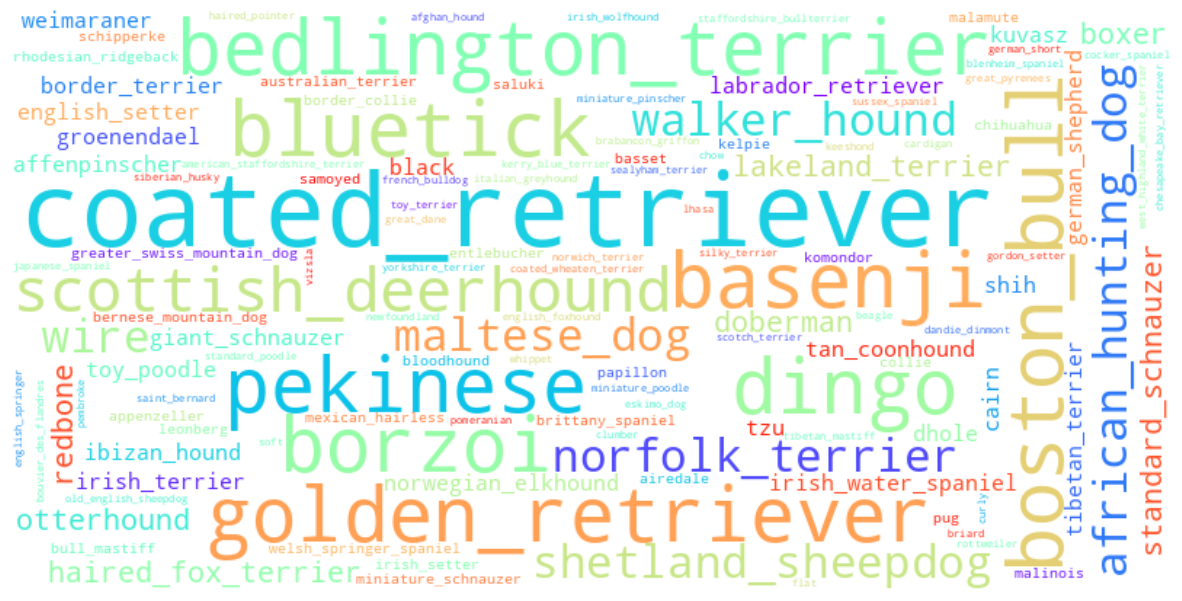

In [5]:
# Show worldcloud for breeds
breeds = labels["breed"].unique().tolist()

text = ' '.join(breeds)
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap="rainbow"
).generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

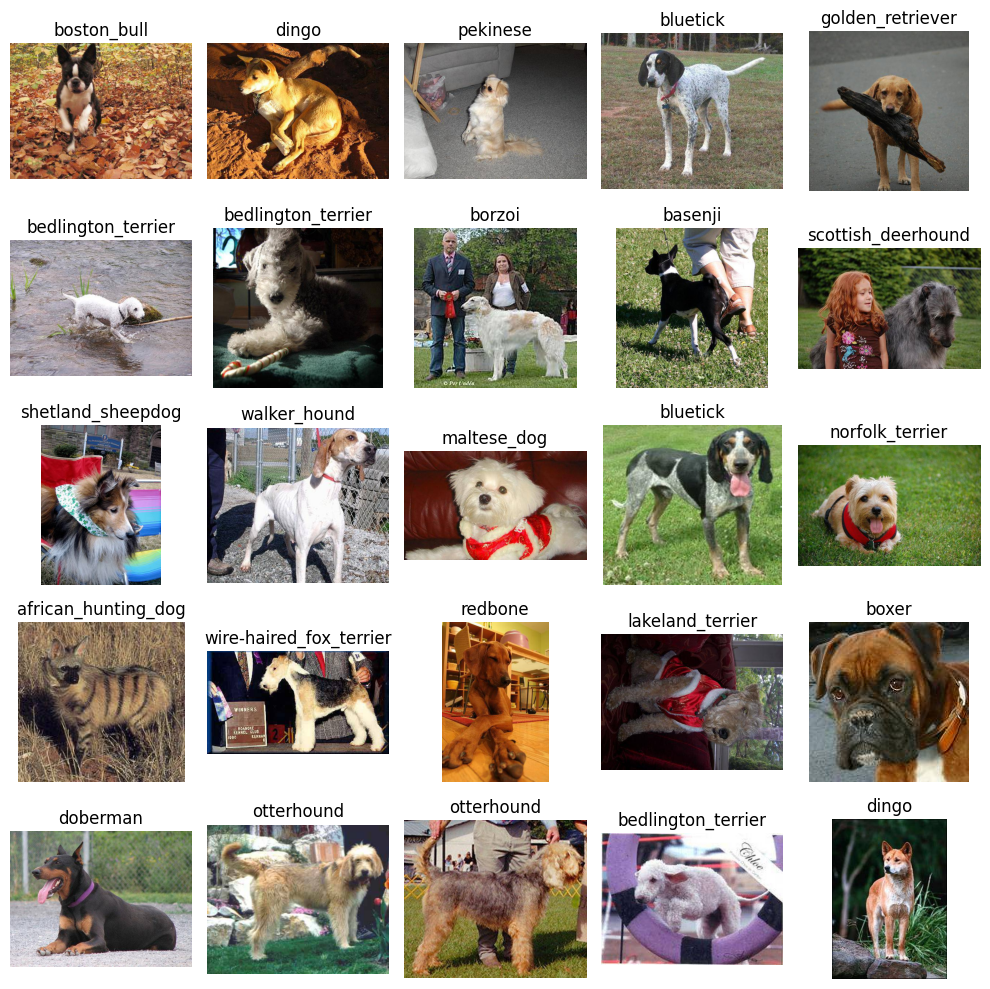

In [6]:
# Visualize train images
nrow = 5
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))

for i,(img_id, breed) in enumerate(labels[["id","breed"]].values[: nrow*ncol]):
    # Extract colored image
    image_path = os.path.join(train_dir, img_id + ".jpg")
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define row & col
    row = i // ncol
    col = i % ncol

    # Plot image
    ax[row,col].imshow(image)
    ax[row,col].set_title(breed)
    ax[row,col].axis("off")
    
plt.tight_layout()
plt.show()


In [7]:
num_breed = labels.breed.nunique()
print(f"Total number of unique Dog Breeds: {num_breed}")

Total number of unique Dog Breeds: 120


In [8]:
# Filter labels
breed = list(labels["breed"].value_counts().keys())
new = sorted(breed,reverse=True)[: num_breed]
labels = labels.query("breed in @new")

# Prepare image_file column
labels['image_file'] = labels['id'].apply(lambda x: x + ".jpg")

labels

id                     breed  \
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull   
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo   
2      001cdf01b096e06d78e9e5112d419397                  pekinese   
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick   
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever   
...                                 ...                       ...   
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi   
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont   
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale   
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher   
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever   

                                 image_file  
0      000bec180eb18c7604dcecc8fe0dba07.jpg  
1      001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2      001cdf01b096e06d78e9e5112d419397.jpg  
3      00214f311d5d2247d5dfe4fe24b2303d.jpg  
4      0021f9ceb3235effd7fcde7f7538ed62.jpg  
...                                     ...  
10217  ffd25009d635cfd16e793503ac5edef0.jpg  
10218  ffd3f636f7f379c51ba3648a9ff8254f.jpg  
10219  ffe2ca6c940cddfee68fa3cc6c63213f.jpg  
10220  ffe5f6d8e2bff356e9482a80a6e29aac.jpg  
10221  fff43b07992508bc822f33d8ffd902ae.jpg  

[10222 rows x 3 columns]

### Data Processing

In [11]:
# Prepare train datasets
image_size = 200

# Define empty train_data
train_data = np.zeros(
    (len(labels), image_size, image_size, 3),
    dtype="float32"
)

for i, img_id in enumerate(labels["image_file"]):
    # Resize image
    img = cv2.resize(
        cv2.imread(train_dir + '/' + img_id, cv2.IMREAD_COLOR),
        ((image_size,image_size))
    )

    # Expand dimensions
    img_array=preprocess_input(
        np.expand_dims(
            np.array(img[...,: : -1].astype(np.float32)).copy(),
            axis=0
        ))
    
    # Populate train_data
    train_data[i] = img_array

# Show first train image
train_data[i]

array([[[ 0.45098042,  0.45098042,  0.4666667 ],
        [ 0.4666667 ,  0.4666667 ,  0.48235297],
        [ 0.5137255 ,  0.5137255 ,  0.52156866],
        ...,
        [-0.42745095, -0.44313723, -0.4352941 ],
        [-0.32549018, -0.32549018, -0.34117645],
        [-0.42745095, -0.42745095, -0.44313723]],

       [[ 0.41960788,  0.41960788,  0.43529415],
        [ 0.48235297,  0.48235297,  0.49803925],
        [ 0.45098042,  0.45098042,  0.4666667 ],
        ...,
        [-0.4823529 , -0.4980392 , -0.49019605],
        [-0.4980392 , -0.5058824 , -0.5058824 ],
        [-0.27843136, -0.27843136, -0.27843136]],

       [[ 0.5137255 ,  0.5137255 ,  0.5294118 ],
        [ 0.43529415,  0.43529415,  0.45882356],
        [ 0.3803922 ,  0.3803922 ,  0.39607847],
        ...,
        [-0.45098037, -0.4588235 , -0.4588235 ],
        [-0.08235294, -0.08235294, -0.08235294],
        [-0.5764706 , -0.5764706 , -0.5764706 ]],

       ...,

       [[ 0.5764706 ,  0.5764706 ,  0.5764706 ],
        [ 0

In [13]:
# Encode breeds
encoder = LabelEncoder()
encoded_breeds = encoder.fit_transform(labels["breed"].values)

In [15]:
# Divide into train & vallidation observations
X_train, X_val, y_train, y_val = train_test_split(
    train_data,
    encoded_breeds,
    test_size=0.2,
    random_state=21111997
)

In [16]:
# Extract train & validation images
# train_images = X_train.values.tolist()
# val_images = X_val.values.tolist()

In [17]:
# # Move training files into train & validation directories 
# # This is required to be consumed by the ImageDataGenerator
# for idx, row in labels.iterrows():
#     # Extract breed & file
#     breed = row['breed']
#     file = row['image_file']

#     if file in train_images:
#         # Build train breed directory
#         if not os.path.exists(os.path.join(train_dir, breed)):
#             os.mkdir(os.path.join(train_dir, breed))

#         # Move train image to correct directory
#         src = os.path.join(train_dir, file)
#         dst = os.path.join(train_dir, breed, file)

#         if os.path.exists(src):
#             shutil.move(src=src, dst=dst)

#             assert not(os.path.exists(src))

#     elif file in val_images:
#         # Build val breed directory
#         if not os.path.exists(os.path.join(val_dir, breed)):
#             os.mkdir(os.path.join(val_dir, breed))

#         # Move train image to correct directory
#         src = os.path.join(train_dir, file)
#         dst = os.path.join(val_dir, breed, file)

#         if os.path.exists(src):
#             shutil.move(src=src, dst=dst)

#             assert not(os.path.exists(src))

#     else:
#         raise Exception(f"{file} was not found in train/val images.\n")

In [18]:
# Define required parameters
image_size = 200
batch_size = 32

In [19]:
# Utilize data augmentation methods to increase the variety of training images
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define train generator
train_generator = train_datagen.flow(
    X_train, 
    y_train, 
    batch_size=batch_size
)

In [20]:
# Define validation generator (without data augmentation)
val_datagen = ImageDataGenerator()

# Define validation generator
val_generator = val_datagen.flow(
    X_val, 
    y_val, 
    batch_size=batch_size
)

In [21]:
# Extract ResNet50V2 trained model, to be fine tuned
resnet_model = ResNet50V2(
    input_shape=(image_size, image_size) + (3,), 
    weights='imagenet', 
    include_top=False
)

# Make layers not trainable
for layer in resnet_model.layers:
    layer.trainable = False

In [22]:
# Build additional layers after the last layer from ResNet model
x = resnet_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# Output layer with num_breed units (number of classes), no activation
prediction = Dense(num_breed, activation='softmax')(x)

# Define Model
model = Model(
    inputs=resnet_model.input, 
    outputs=prediction
)

In [23]:
# Compile Model
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss, # 'sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 50, 50,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 50, 50,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 52, 52,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 50, 50,    │          0 │ conv2_block1_0_c

 Total params: 26,358,136 (100.55 MB)

 Trainable params: 2,789,240 (10.64 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [25]:
# Fit model
history = model.fit(
    train_generator,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=X_val.shape[0] // batch_size
)

Epoch 1/15


/Users/simongarciamorillo/Library/CloudStorage/OneDrive-Personal/Documents/ITBA/Técnicas y Algoritmos de Aprendizaje Automático/TP/itba-ml/.itba_ml_venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/Users/simongarciamorillo/Library/CloudStorage/OneDrive-Personal/Documents/ITBA/Técnicas y Algoritmos de Aprendizaje Automático/TP/itba-ml/.itba_ml_venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 144s 553ms/step - accuracy: 0.2017 - loss: 3.5399 - val_accuracy: 0.5709 - val_loss: 1.4473
Epoch 2/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 1:53 448ms/step - accuracy: 0.5000 - loss: 1.8672

2024-05-07 17:17:06.389945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/simongarciamorillo/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5000 - loss: 1.8672 - val_accuracy: 0.4483 - val_loss: 1.4590
Epoch 3/15


2024-05-07 17:17:06.833206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 144s 561ms/step - accuracy: 0.4929 - loss: 1.8768 - val_accuracy: 0.6225 - val_loss: 1.2827
Epoch 4/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 2:05 493ms/step - accuracy: 0.5625 - loss: 1.2719

2024-05-07 17:19:31.217201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.2719 - val_accuracy: 0.4483 - val_loss: 1.9974
Epoch 5/15


2024-05-07 17:19:31.625328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 144s 560ms/step - accuracy: 0.5526 - loss: 1.6307 - val_accuracy: 0.6508 - val_loss: 1.2683
Epoch 6/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 1:59 472ms/step - accuracy: 0.5312 - loss: 1.8043

2024-05-07 17:21:55.652962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.8043 - val_accuracy: 0.7586 - val_loss: 0.9605
Epoch 7/15


2024-05-07 17:21:56.097532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 143s 559ms/step - accuracy: 0.6028 - loss: 1.4509 - val_accuracy: 0.6463 - val_loss: 1.2529
Epoch 8/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - accuracy: 0.5625 - loss: 1.2762

2024-05-07 17:24:19.910636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 1.2762 - val_accuracy: 0.5517 - val_loss: 1.2523
Epoch 9/15


2024-05-07 17:24:20.300572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 142s 554ms/step - accuracy: 0.6184 - loss: 1.3480 - val_accuracy: 0.6533 - val_loss: 1.2648
Epoch 10/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 1:52 443ms/step - accuracy: 0.6250 - loss: 1.4939

2024-05-07 17:26:42.570481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 1.4939 - val_accuracy: 0.6897 - val_loss: 0.6414
Epoch 11/15


2024-05-07 17:26:42.962957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 139s 544ms/step - accuracy: 0.6368 - loss: 1.2655 - val_accuracy: 0.6627 - val_loss: 1.2132
Epoch 12/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 1:49 430ms/step - accuracy: 0.6250 - loss: 1.3795

2024-05-07 17:29:02.830336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 1.3795 - val_accuracy: 0.7241 - val_loss: 1.1850
Epoch 13/15


2024-05-07 17:29:03.231041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 141s 550ms/step - accuracy: 0.6617 - loss: 1.1918 - val_accuracy: 0.6657 - val_loss: 1.2481
Epoch 14/15
  1/255 ━━━━━━━━━━━━━━━━━━━━ 1:50 434ms/step - accuracy: 0.7500 - loss: 0.9802

2024-05-07 17:31:24.528508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.9802 - val_accuracy: 0.5862 - val_loss: 1.7906
Epoch 15/15


2024-05-07 17:31:24.925104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 ━━━━━━━━━━━━━━━━━━━━ 140s 548ms/step - accuracy: 0.7005 - loss: 1.0664 - val_accuracy: 0.6652 - val_loss: 1.2591


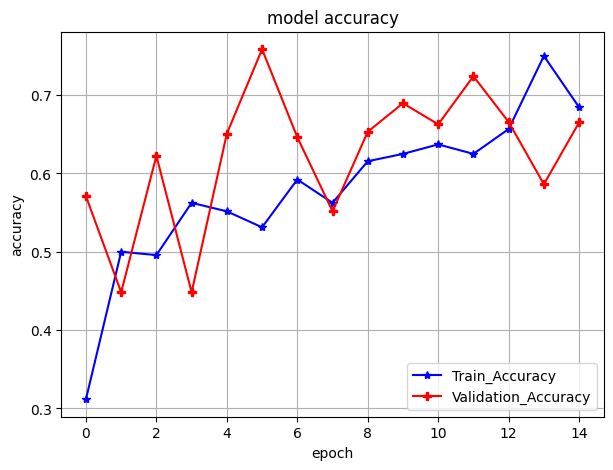

In [27]:
# Visualize train & validation accuracy
plt.figure(figsize=(7,5))

plt.plot(
    history.history['accuracy'],
    label="Train_Accuracy",
    color="blue",
    marker="*"
)

plt.plot(
    history.history['val_accuracy'],
    label="Validation_Accuracy",
    color="red",
    marker="P"
)

plt.grid(True)
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

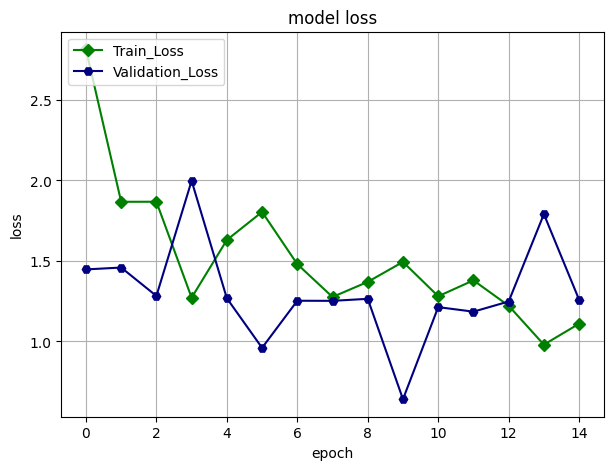

In [28]:
# Visualize train & validation loss
plt.figure(figsize=(7,5))

plt.plot(
    history.history['loss'],
    color="green",
    marker="D"
)

plt.plot(
    history.history['val_loss'],
    color="navy",
    marker="H"
)

plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(
    ['Train_Loss', 'Validation_Loss'], 
    loc='upper left'
)

plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step


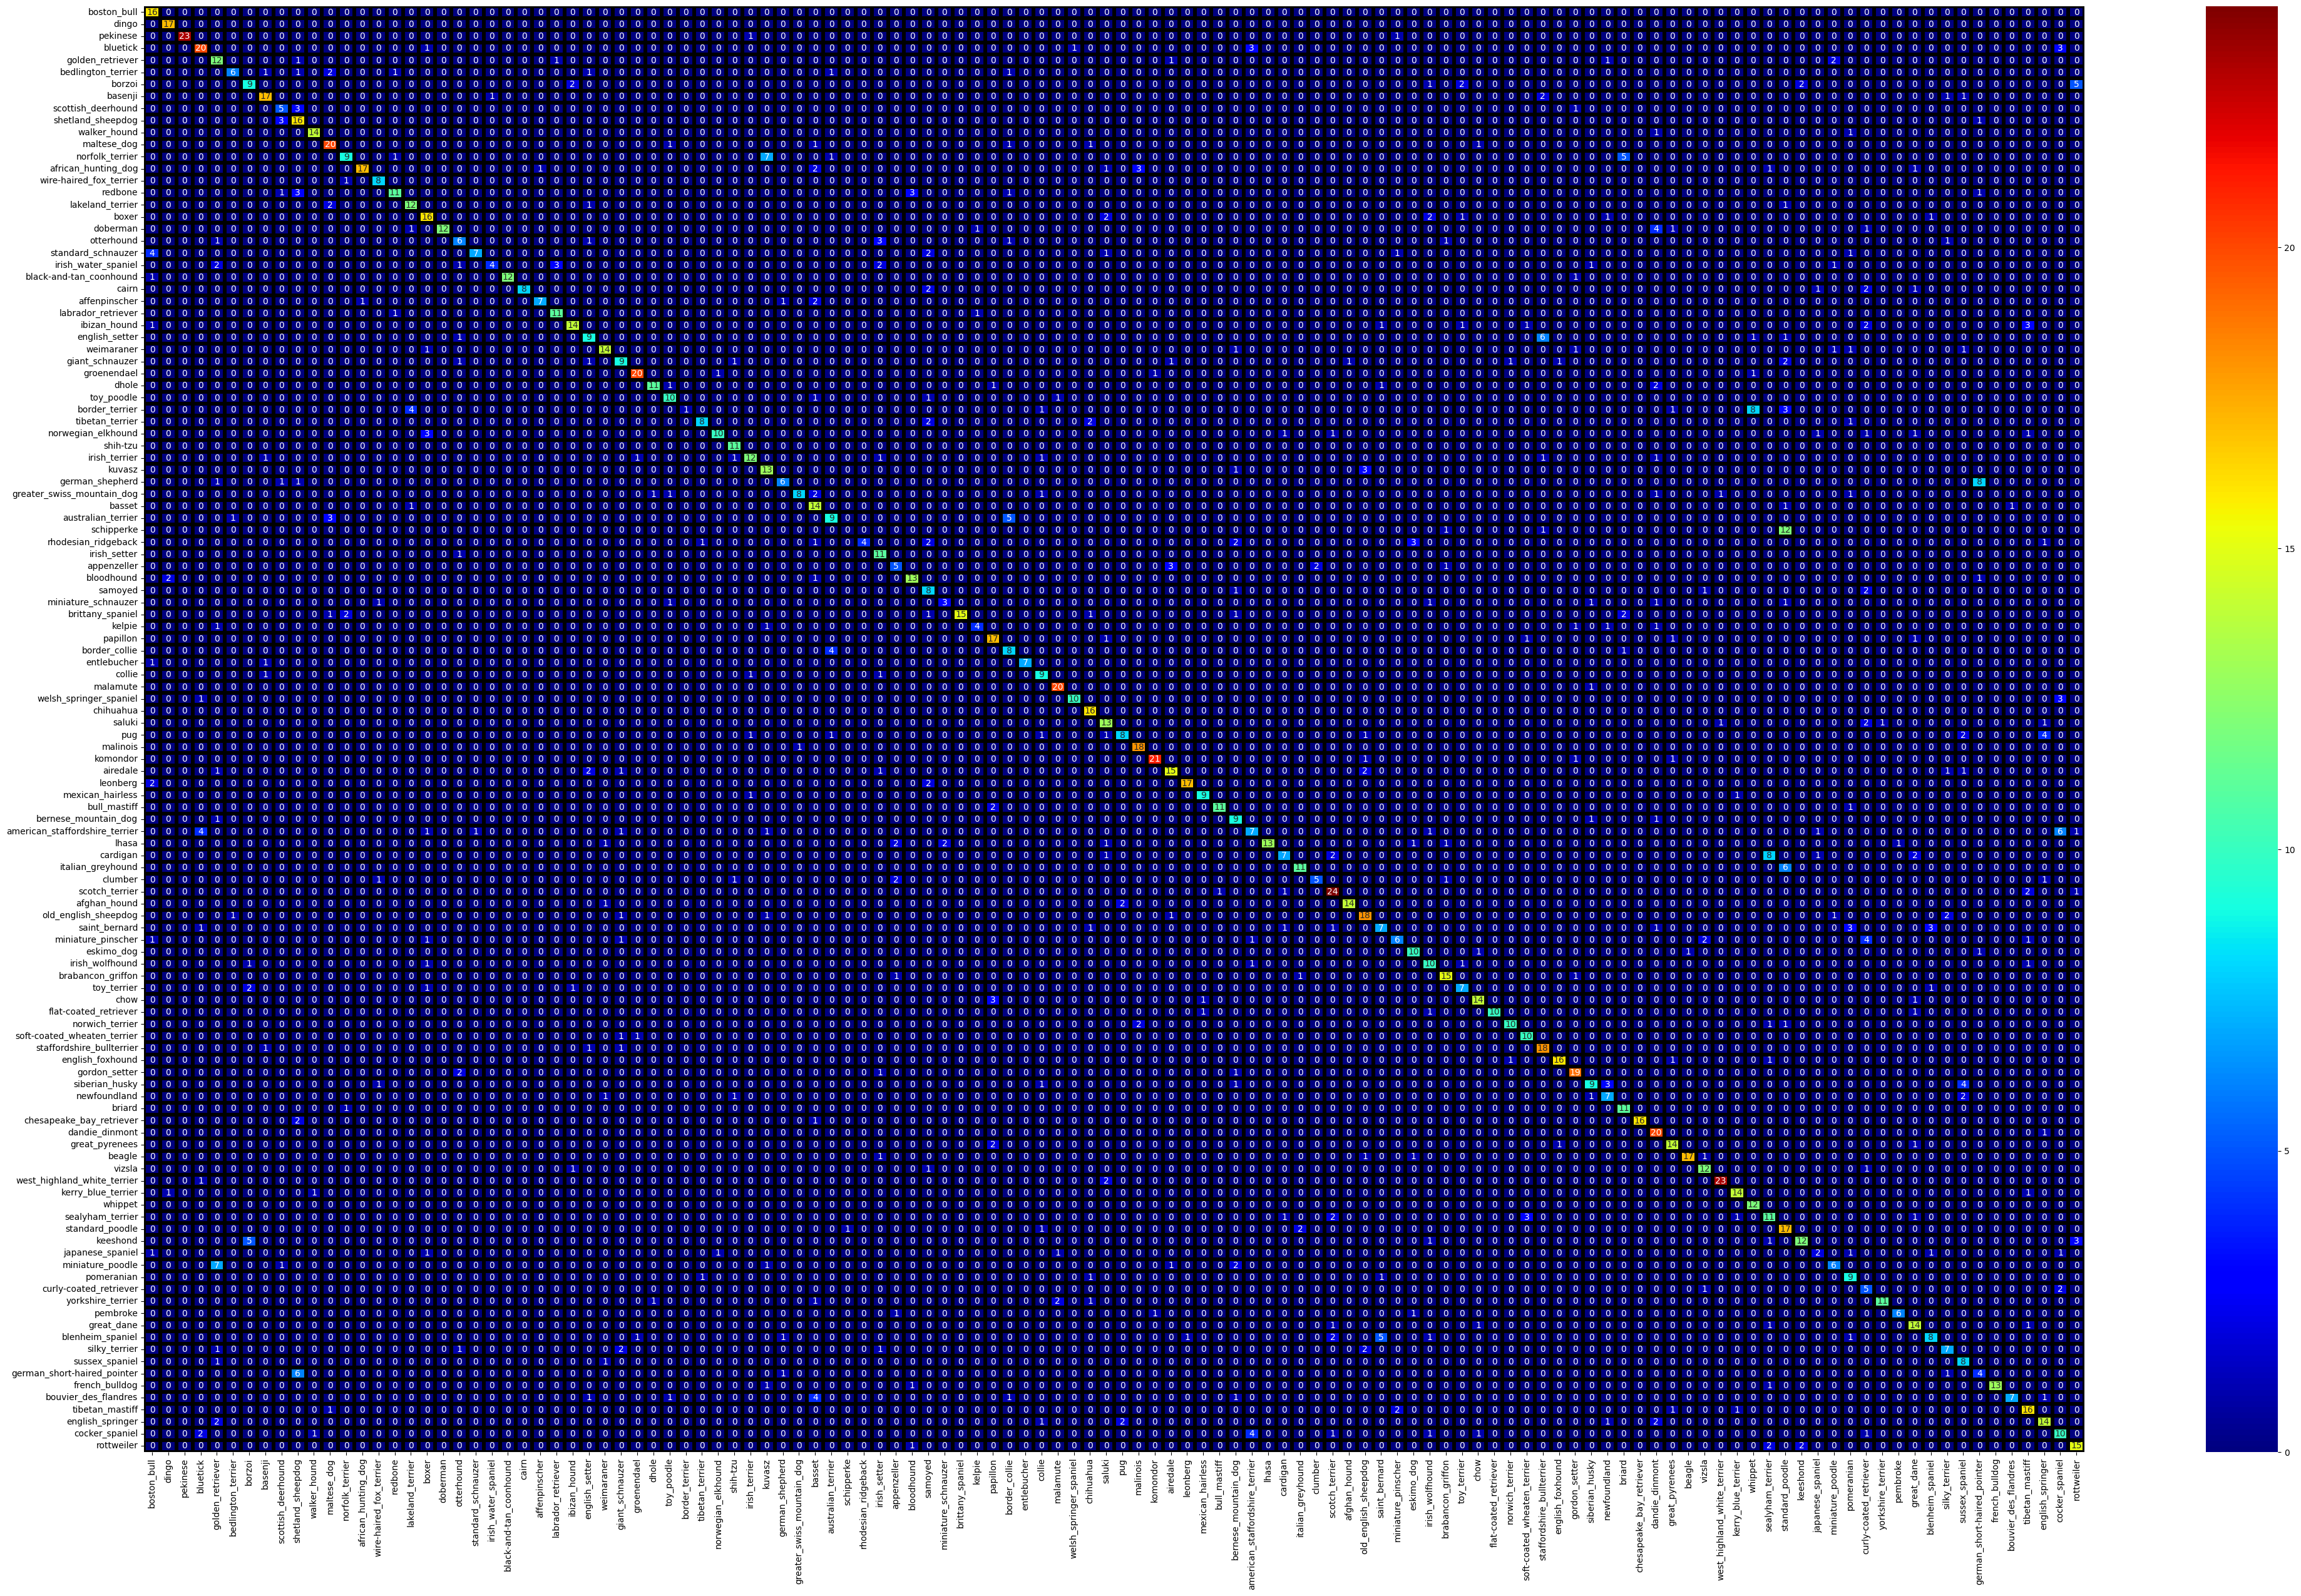

In [31]:
# Extract confusion matrix
pre = model.predict(X_val)
predict = np.argmax(pre, axis=1)
confusion_matrix = confusion_matrix(y_val, predict)

# Plot confusion matrix
breeds = labels["breed"].unique().tolist()

plt.figure(figsize=(50,30))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="jet",
    lw=4,
    linecolor="black",
    xticklabels=breeds,
    yticklabels=breeds
)

plt.show()

In [32]:
print(classification_report(
    y_val,
    predict,
    target_names=breeds
))

                                precision    recall  f1-score   support

                   boston_bull       0.59      1.00      0.74        16
                         dingo       0.85      1.00      0.92        17
                      pekinese       1.00      0.92      0.96        25
                      bluetick       0.69      0.71      0.70        28
              golden_retriever       0.40      0.67      0.50        18
            bedlington_terrier       0.75      0.43      0.55        14
                        borzoi       0.53      0.43      0.47        21
                       basenji       0.77      0.77      0.77        22
            scottish_deerhound       0.45      0.56      0.50         9
             shetland_sheepdog       0.48      0.80      0.60        20
                  walker_hound       0.88      0.88      0.88        16
                   maltese_dog       0.69      0.80      0.74        25
               norfolk_terrier       0.69      0.39      0.50  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

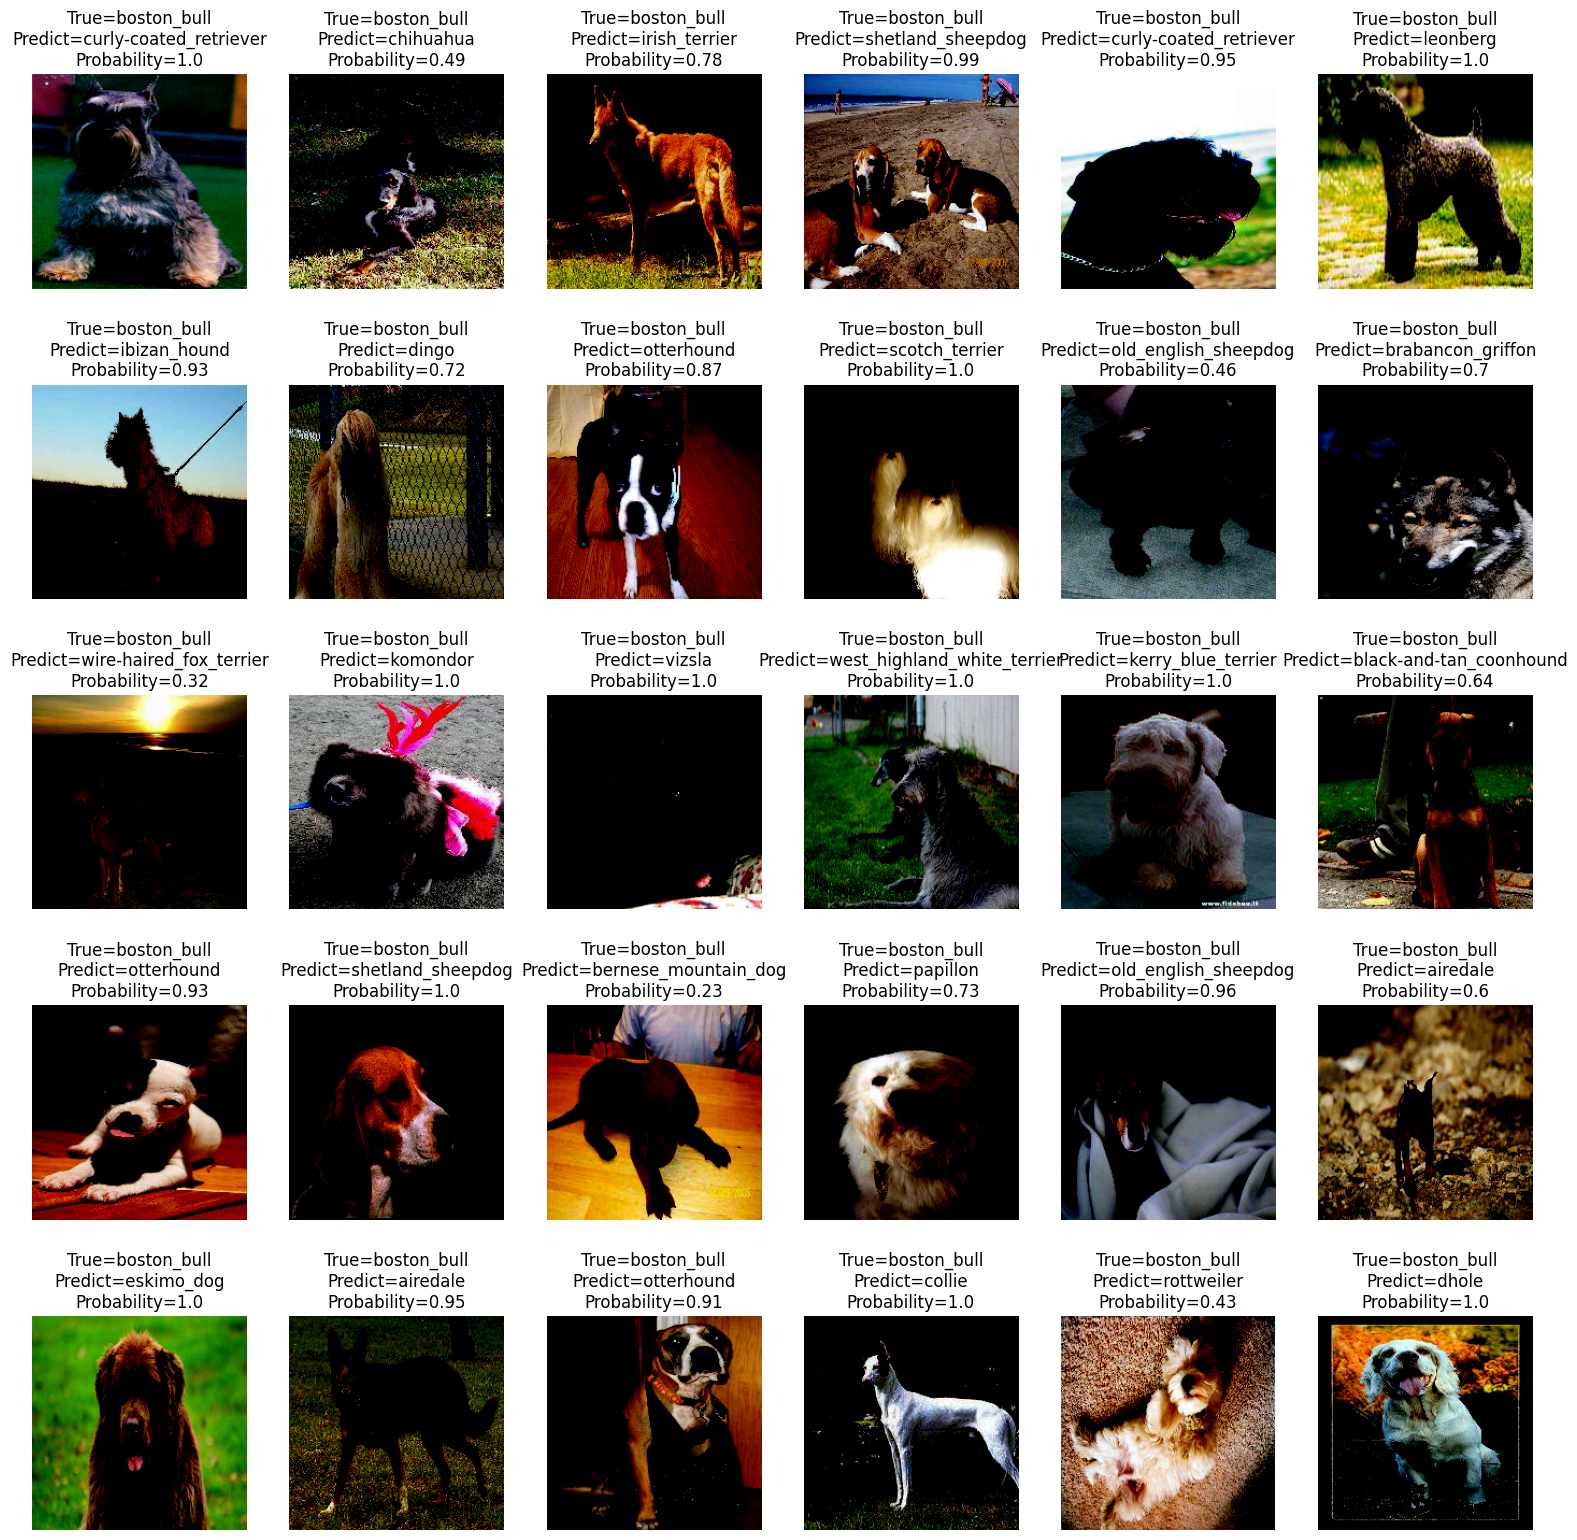

In [33]:
# Show predictions for Validation
row = 5
column = 6

fig, ax = plt.subplots(row, column)
fig.set_size_inches(15, 15)

index = 0
for m in range(0, row):
    for n in range(0, column):
        true_data = np.argmax(y_val[index])  # Get the true class label
        pred_data = predict[index]  # Get the predicted class label
        probability = round(pre[index][pred_data], 2)
        
        ax[m][n].axis("off")
        ax[m][n].set_title("True=" + str(breeds[true_data]) + "\nPredict=" + str(breeds[pred_data]) + "\nProbability=" + str(probability))
        ax[m][n].imshow(X_val[index])
        index += 1

plt.subplots_adjust(
    left=0, 
    bottom=0, 
    right=1, 
    top=1, 
    wspace=0.2, 
    hspace=0.20
)

plt.show()
